In [2]:
import config
from forklens import train
from forklens.dataset import ShapeDataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time

In [3]:
tr = train.Train()
model_file = "./model/example_model598"
model = tr.load_model(path=model_file,strict=True)

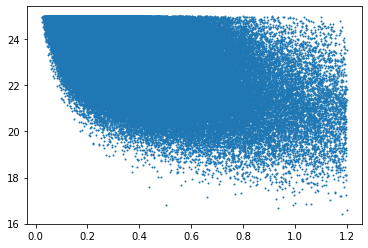

In [4]:
# Load data catalog
with fits.open('../../data/disk_gal_catalog_cut_25_1.2.fits') as f:
    mag_cat = f[0].data
    size_cat = f[3].data
plt.scatter(size_cat[::10],mag_cat[::10],s=1)

## Shape Measurement with CNN

In [4]:
# Generate data
def dataframe(num, seed=12345):
    
    num = int(num/2)
    rng1 = np.random.RandomState(seed)
    Gal_Hlr   = size_cat[rng1.randint(0,mag_cat.shape[0],size=num)]
    Gal_Hlr   = np.concatenate((Gal_Hlr, Gal_Hlr), axis=0)
    Gal_Mag   = mag_cat[rng1.randint(0,mag_cat.shape[0],size=num)]
    Gal_Mag   = np.concatenate((Gal_Mag, Gal_Mag), axis=0)
    Gal_e     = rng1.random((num,2))*(-0.6-0.6)+0.6
    Gal_e     = np.concatenate((Gal_e, Gal_e*-1), axis=0)

    rng2 = np.random.RandomState(seed+1)
    PSF_randint = rng2.randint(0,10000,size=num)
    PSF_randint = np.concatenate((PSF_randint, PSF_randint), axis=0)
    
    gal_pars = {}
    gal_pars["e1"] = Gal_e[:,0]
    gal_pars["e2"] = Gal_e[:,1]
    gal_pars["hlr_disk"] = Gal_Hlr
    gal_pars["mag_i"] = Gal_Mag
    
    psf_pars = {}
    psf_pars['randint'] = PSF_randint
    
    return gal_pars, psf_pars

In [5]:
# Get data loader
nSims = 5000
GalCat, PSFCat = dataframe(nSims, seed=11111)
test_ds = ShapeDataset(GalCat, PSFCat)
test_dl = DataLoader(test_ds, 
                      batch_size=config.train['batch_size'], 
                      num_workers=config.train['workers'])

pred, true, snr, loss = tr._predictFunc(test_dl,model)
print('Test LOSS:',loss)
diff = pred - true

Test LOSS: 0.071518017846345


In [6]:
snr[np.where(snr[:,1]>50),1] = 50

/tmp/ipykernel_3013775/3288538836.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  clb.ax.set_yticklabels([10,20,30,40,'>50']);


<Figure size 576x432 with 0 Axes>

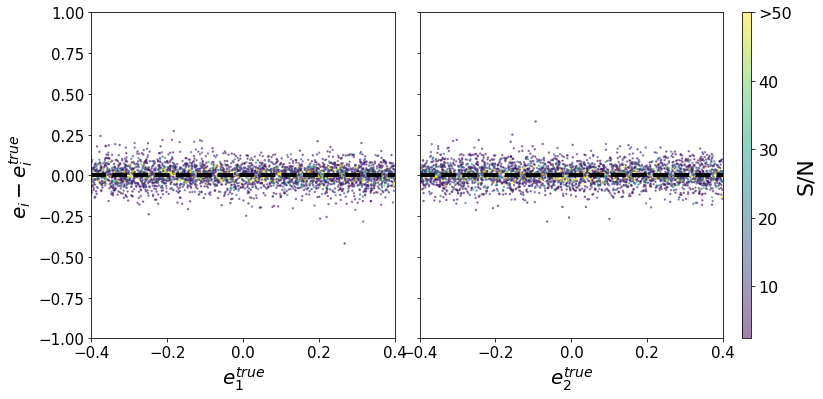

In [7]:
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

axes[0].scatter(true[:,1]*0.6, diff[:,1]*0.6, s=2, c=snr[:,1], alpha=0.5)
im = axes[1].scatter(true[:,2]*0.6, diff[:,2]*0.6, s=2, c=snr[:,1], alpha=0.5)
axes[0].set_ylim(-1,1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=4)
    
axes[0].set_xlabel(r'$e^{true}_1$',fontsize=20)
axes[1].set_xlabel(r'$e^{true}_2$',fontsize=20)
axes[0].set_ylabel(r'$e_i-e^{true}_i$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

# Large galaxies with large ellipticity are over the stamp cut
axes[0].set_xlim(-0.4,0.4)
axes[1].set_xlim(-0.4,0.4)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.82, 0.125, 0.01, 0.755])
clb = fig1.colorbar(im, cax=cbar_ax)

clb.ax.tick_params(labelsize=16) 
clb.set_label('S/N', fontsize=22)
clb.ax.set_yticklabels([10,20,30,40,'>50']);

## Shear Measurement with CNN

In [5]:
from forklens.dataset import ShearDataset

from scipy.optimize import curve_fit

In [6]:
case_num = 100
real_num = 5000

seed = 33333
rng = np.random.RandomState(seed)
Gal_Shear   = rng.random((case_num,2))*(-0.1-0.1)+0.1

for i in range(case_num):
    
    sub_seed = seed + i
    rng = np.random.RandomState(sub_seed)
    
    Gal_Hlr     = size_cat[rng.randint(0,mag_cat.shape[0],size=int(real_num))]
    # Gal_Hlr     = np.concatenate((Gal_Hlr, Gal_Hlr), axis=0)
    Gal_Mag     = mag_cat[rng.randint(0,mag_cat.shape[0],size=int(real_num))]
    # Gal_Mag     = np.concatenate((Gal_Mag, Gal_Mag), axis=0)
    
    Gal_Phi     = rng.random(size=int(real_num/2))*(-np.pi/2-np.pi/2)+np.pi/2
    Gal_Phi     = np.concatenate((Gal_Phi, Gal_Phi+np.pi/2), axis=0)
    Gal_AxRatio = rng.random(size=int(real_num/2))*(0.5-1)+1
    Gal_AxRatio = np.concatenate((Gal_AxRatio, Gal_AxRatio), axis=0)
    
    Gal_E1 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.cos(Gal_Phi*2)
    Gal_E2 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.sin(Gal_Phi*2)

    PSF_randint = rng.randint(0,high=10000,size=real_num)
    
    if i == 0:
        gal_pars = {}
        gal_pars["e1"] = Gal_E1
        gal_pars["e2"] = Gal_E2
        gal_pars["hlr_disk"] = Gal_Hlr
        gal_pars["mag_i"] = Gal_Mag
        gal_pars['randint'] = PSF_randint
    else:
        gal_pars["e1"] = np.vstack((gal_pars["e1"], Gal_E1))
        gal_pars["e2"] = np.vstack((gal_pars["e2"], Gal_E2))
        gal_pars["hlr_disk"] = np.vstack((gal_pars["hlr_disk"], Gal_Hlr))
        gal_pars["mag_i"] = np.vstack((gal_pars["mag_i"], Gal_Mag))
        gal_pars['randint'] = np.vstack((gal_pars["randint"], PSF_randint))

shear_pars = {}
shear_pars['shear'] = Gal_Shear

In [7]:
shear_ds = ShearDataset(shear_pars, gal_pars)
shear_dl = DataLoader(shear_ds, 
                      batch_size=config.train['batch_size'], 
                      num_workers=40)

pred, true, _, _ = tr._predictFunc(shear_dl,model)
diff = pred - true

In [8]:
# Save
hdu0 = fits.PrimaryHDU(pred[:,0:5])
hdu1 = fits.ImageHDU(Gal_Shear[:,0])
hdul = fits.HDUList([hdu0,hdu1])
hdul.writeto('TypeII_dataset_100case_5000real_-0.1-0.1shear.fits',overwrite=True)

In [13]:
results = pred[:,1:].reshape(case_num,real_num,4)
g = np.zeros((case_num,2))
for i in range(case_num):
    g[i,0] = np.mean(results[i,:,0])*0.6
    g[i,1] = np.mean(results[i,:,1])*0.6


def linear_func(x,a,b):
    return x*a+b

popt,_ = curve_fit(linear_func,shear_pars['shear'][:,0],g[:,0]-shear_pars['shear'][:,0])
print(popt)

[-0.01038797 -0.00070743]


Text(0.5, 1.0, 'CNN shear measurement')

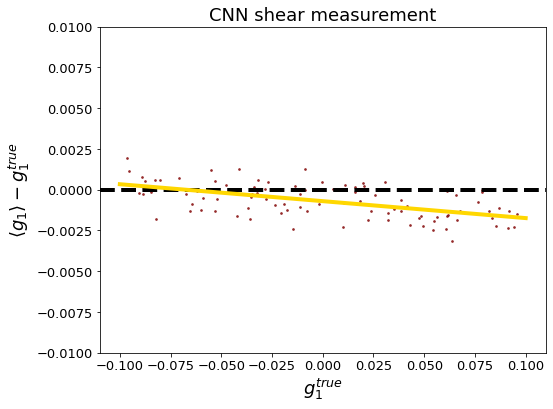

In [14]:
plt.figure(figsize=(8,6))

plt.scatter(shear_pars['shear'][:,0],g[:,0]-shear_pars['shear'][:,0],s=3,color='maroon',alpha=0.7)

plt.axhline(0,color='k',linestyle='--',linewidth=4)
x = np.linspace(-0.1,0.1)
y = linear_func(x,popt[0],popt[1])
plt.plot(x,y,color='gold',linewidth=4,label=r'$10^3m=%.2f,10^4c=%.2f$'%(popt[0]/1e-3,popt[1]/1e-4))

plt.ylim(-0.01,0.01)
plt.tick_params(axis='both',which='major',labelsize=13)
plt.xlabel(r'$g^{true}_1$',fontsize=18)
plt.ylabel(r'$\left<g_1\right>-g^{true}_1$',fontsize=18)
plt.title('CNN shear measurement', fontsize=18)

### Generate dataset for NN calibration

In [4]:
from forklens.dataset import CaliDataset

In [5]:
case_num = 5000
real_num = 2000

seed = 55555
rng = np.random.RandomState(seed)
Gal_Shear   = rng.random((case_num,2))*(-0.1-0.1)+0.1

# This loop is not efficient
for i in range(case_num):
    
    sub_seed = seed + i
    rng = np.random.RandomState(sub_seed)
    
    Gal_Hlr     = size_cat[rng.randint(0,mag_cat.shape[0],size=1)]
    # Gal_Hlr     = np.concatenate((Gal_Hlr, Gal_Hlr), axis=0)
    Gal_Mag     = mag_cat[rng.randint(0,mag_cat.shape[0],size=1)]
    # Gal_Mag     = np.concatenate((Gal_Mag, Gal_Mag), axis=0)
    
    Gal_Phi     = rng.random(size=int(real_num/2))*(-np.pi/2-np.pi/2)+np.pi/2
    Gal_Phi     = np.concatenate((Gal_Phi, Gal_Phi+np.pi/2), axis=0)
    Gal_AxRatio = rng.random(size=int(real_num/2))*(0.5-1)+1
    Gal_AxRatio = np.concatenate((Gal_AxRatio, Gal_AxRatio), axis=0)
    
    Gal_E1 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.cos(Gal_Phi*2)
    Gal_E2 = (1-Gal_AxRatio)/(1+Gal_AxRatio)*np.sin(Gal_Phi*2)

    PSF_randint = rng.randint(0,high=10000,size=1)
    
    if i == 0:
        gal_pars = {}
        gal_pars["e1"] = Gal_E1
        gal_pars["e2"] = Gal_E2
        gal_pars["hlr_disk"] = Gal_Hlr
        gal_pars["mag_i"] = Gal_Mag
        gal_pars['randint'] = PSF_randint
    else:
        gal_pars["e1"] = np.vstack((gal_pars["e1"], Gal_E1))
        gal_pars["e2"] = np.vstack((gal_pars["e2"], Gal_E2))
        gal_pars["hlr_disk"] = np.vstack((gal_pars["hlr_disk"], Gal_Hlr))
        gal_pars["mag_i"] = np.vstack((gal_pars["mag_i"], Gal_Mag))
        gal_pars['randint'] = np.vstack((gal_pars["randint"], PSF_randint))

shear_pars = {}
shear_pars['shear'] = Gal_Shear

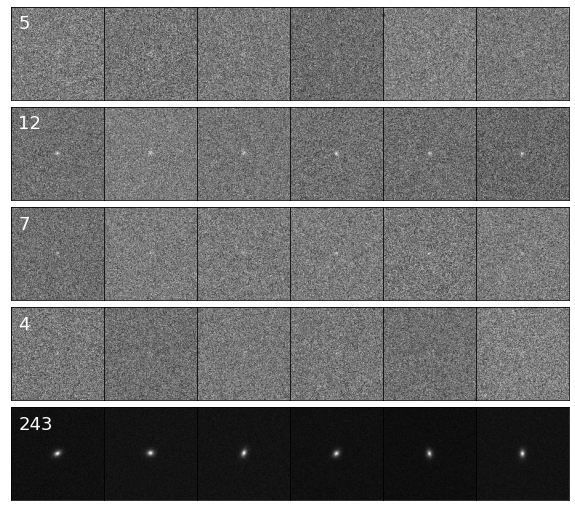

In [7]:
show_ds = CaliDataset(shear_pars, gal_pars)

# cases = np.zeros((128*5,128*6))
# for i in range(5):
#     for j in range(6):
#         gal_im = show_ds.__getitem__(i*real_num+j)['gal_image'][0]
#         cases[int(128*i):int(128*(i+1)),int(128*j):int(128*(j+1))] = gal_im.copy()

plt.figure(figsize=(10,10))

for i in range(5):
    for j in range(6):
        plt.subplot(5,6,i*6+j+1)
        #print(j)
        if j == 0:
            plt.text(10,30,'%d'%show_ds.__getitem__(i*real_num+j)['snr'],color='white',fontsize=18)
        gal_im = show_ds.__getitem__(i*real_num+j)['gal_image'][0]
        plt.imshow(gal_im,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
plt.subplots_adjust(wspace=0., hspace=-0.3)

In [8]:
start = time.time()

cali_ds = CaliDataset(shear_pars, gal_pars)

cali_dl = DataLoader(cali_ds, 
                      batch_size=config.train['batch_size'],
                      num_workers=40)

cali_pred, cali_true, cali_snr, loss = tr._predictFunc(cali_dl,model)

(time.time()-start)/60

150.65402109622954

In [11]:
dataset = np.zeros((case_num*real_num,8))
dataset[:,0:5] = cali_pred
box = np.zeros((case_num*real_num,2))
for i in range(case_num*real_num):
    idx = i//real_num
    #print(idx)
    box[i,0:2] = Gal_Shear[idx,:]
    #box[i,2] = Gal_SNR[idx]
dataset[:,5:7] = box
dataset[:,7] = cali_snr[:,1]

In [12]:
# Save for NN calibration
hdu = fits.PrimaryHDU(dataset)
hdul = fits.HDUList([hdu])
hdul.writeto('TypeI_dataset_5000case_2000real_-0.1-0.1shear.fits')